# Engineering features for a model from train set

In [1]:
# Import Libraries
# Data
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import random
from datetime import datetime, timedelta

from copy import deepcopy

#Viz
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(font='Helvetica') # Futura? Calibri Light? 
sns.set_style("white")
sns.set_theme(style='ticks')
sns.set_context('talk')

In [2]:
from statsmodels.graphics import tsaplots

## Import training data

In [225]:
path = 'C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/train_set_2018_01_01_01_2022_09_16_06.csv'
train_set = pd.read_csv(path, index_col=0)
train_set.index = pd.DatetimeIndex(train_set.index)
train_set = train_set.rename(columns={'Total Snow (cm)':'tot_snow'})

In [226]:
train_set.columns

Index(['hourly_price', 'or_10s', 'or_10ns', 'or_30', 'Hour', 'market_demand',
       'ont_demand', 'Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14', 'Year', 'Month', 'Day', 'max_t', 'min_t',
       'mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip',
       'gust_dir', 'gust_speed'],
      dtype='object')

### General

(-10.0, 150.0)

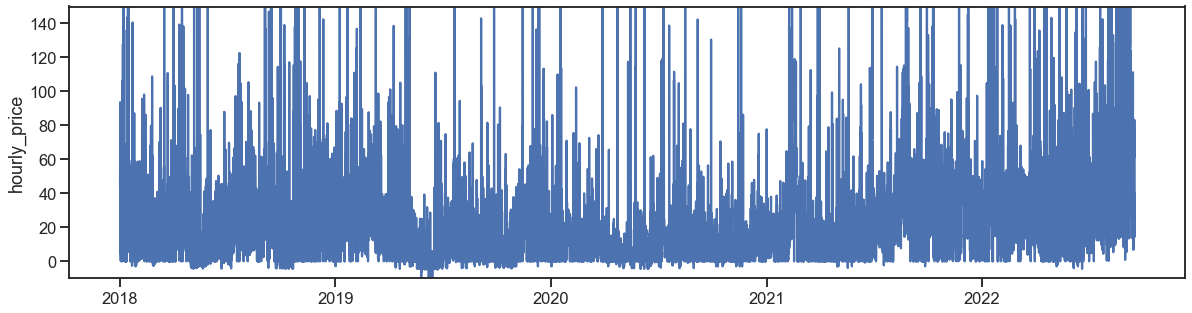

In [1616]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(data=train_set, y='hourly_price', x=train_set.index, ax=ax)

ax.set_ylim([-10, 150])

## Time series features and autocorrelation

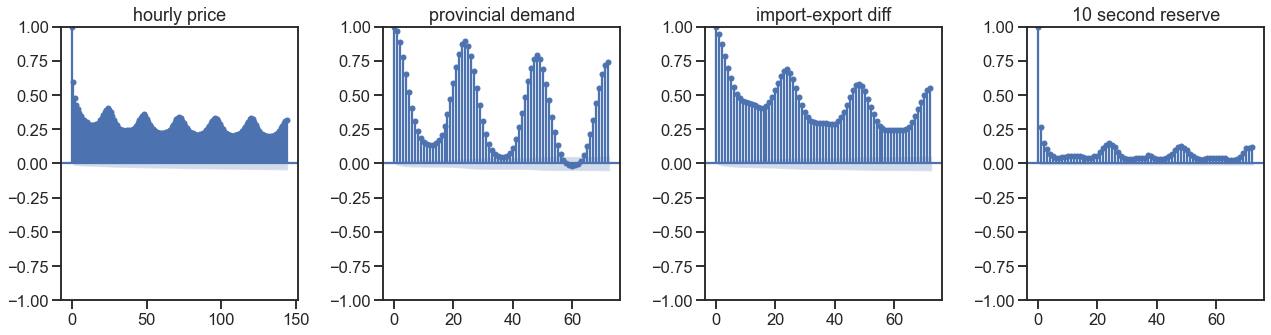

In [1265]:
fig, ax = plt.subplots(1,4, figsize=(18,5))
#plot autocorrelation function
train_set['imp-exp'] = train_set['Imp.14'] - np.abs(train_set['Exp.14'])

tsaplots.plot_acf(train_set['hourly_price'], lags=144, ax=ax[0])
tsaplots.plot_acf(train_set['ont_demand'], lags=72, ax=ax[1])
tsaplots.plot_acf(train_set['imp-exp'], lags=72, ax=ax[2])
tsaplots.plot_acf(train_set['or_10ns'], lags=72, ax=ax[3])

at = ['hourly price', 'provincial demand', 'import-export diff','10 second reserve']
for i, a in enumerate(ax):
    a.set_title(at[i])

plt.tight_layout()

<AxesSubplot:>

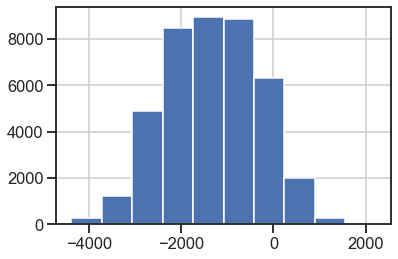

In [1263]:
train_set['ramp_total'].hist()

In [146]:
train_set['hourly_price'].diff()

2018-01-01 01:00:00      NaN
2018-01-01 02:00:00    -7.70
2018-01-01 03:00:00    50.01
2018-01-01 04:00:00   -38.82
2018-01-01 05:00:00   -40.43
                       ...  
2022-09-16 02:00:00    11.85
2022-09-16 03:00:00   -17.61
2022-09-16 04:00:00     0.02
2022-09-16 05:00:00     8.96
2022-09-16 06:00:00    14.89
Name: hourly_price, Length: 41262, dtype: float64

differenced

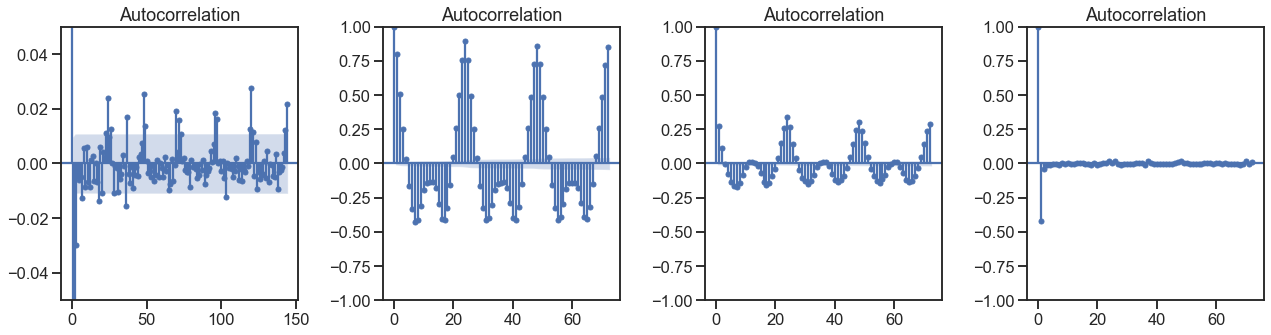

In [155]:
fig, ax = plt.subplots(1,4, figsize=(18,5))
#plot autocorrelation function
tsaplots.plot_acf(train_set['hourly_price'].diff()[1:], lags=144, ax=ax[0])
tsaplots.plot_acf(train_set['ont_demand'].diff(1)[1:], lags=72, ax=ax[1])
tsaplots.plot_acf(train_set['Flow.14'].diff(1)[1:], lags=72, ax=ax[2])
tsaplots.plot_acf(train_set['or_10ns'].diff()[1:], lags=72, ax=ax[3])

ax[0].set_ylim([-0.05,0.05])

plt.tight_layout()

We have some outlier values - my hypothesis is they are related to weather events or outages (but we don't have supply data oh well)

0.3600364156216469

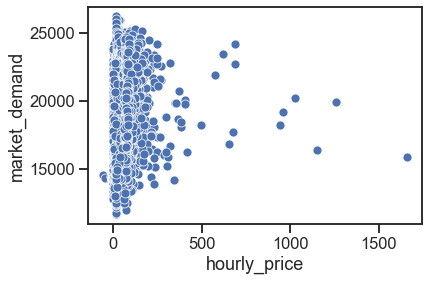

In [78]:
sns.scatterplot(x=train_set['hourly_price'], y=train_set['market_demand'].shift(24))
train_set['hourly_price'].corr(train_set['market_demand'].shift(24))

In [144]:
train_set['hourly_price']#.shift(0)

2018-01-01 01:00:00    51.29
2018-01-01 02:00:00    43.59
2018-01-01 03:00:00    93.60
2018-01-01 04:00:00    54.78
2018-01-01 05:00:00    14.35
                       ...  
2022-09-16 02:00:00    31.98
2022-09-16 03:00:00    14.37
2022-09-16 04:00:00    14.39
2022-09-16 05:00:00    23.35
2022-09-16 06:00:00    38.24
Name: hourly_price, Length: 41262, dtype: float64

In [86]:
def shift_hours_df(col, shift_size):
    shift_df = pd.concat([train_set[col].shift(i) for i in range(shift_size)], axis=1)
    shift_df.columns = [col + str(j) for j in range(shift_size)]

    return shift_df

shift_hours_df('market_demand', 49).head()

,market_demand0,market_demand1,market_demand2,market_demand3,market_demand4,market_demand5,market_demand6,market_demand7,market_demand8,market_demand9,...,market_demand15,market_demand16,market_demand17,market_demand18,market_demand19,market_demand20,market_demand21,market_demand22,market_demand23,market_demand24
2018-01-01 01:00:00,18974,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 02:00:00,18447,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 03:00:00,18453,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 04:00:00,18662,18453.0,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 05:00:00,18060,18662.0,18453.0,18447.0,18974.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Heatmap

<AxesSubplot:>

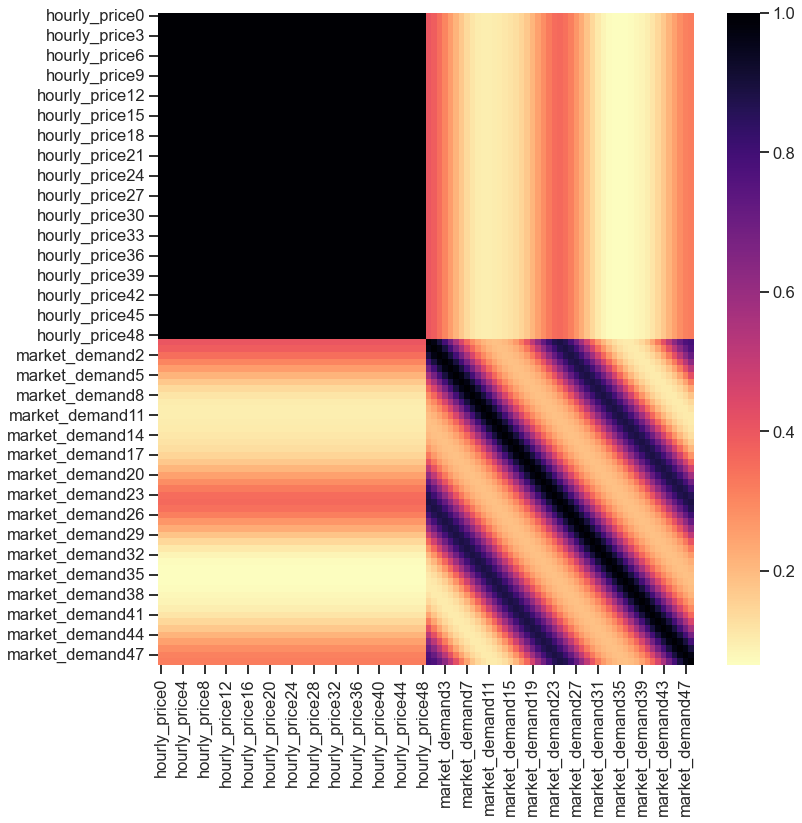

In [97]:
fig, ax = plt.subplots(figsize=(12,12))

price_dup = pd.concat([pd.DataFrame(train_set['hourly_price']).T]*49).T
price_dup.columns = ['hourly_price'+str(i) for i in range(49)]

dem_hm = pd.concat([price_dup, shift_hours_df('market_demand', 49)], axis=1)
sns.heatmap(dem_hm.corr(), ax=ax, cmap='magma_r')

In [355]:
col='hourly_price'
shift_size=49
hrs_ahead = pd.concat([train_set[col].shift(-i) for i in range(shift_size)], axis=1)
hrs_ahead.columns = [col + str(j) for j in range(shift_size)]
hrs_ahead.head()

,hourly_price0,hourly_price1,hourly_price2,hourly_price3,hourly_price4,hourly_price5,hourly_price6,hourly_price7,hourly_price8,hourly_price9,...,hourly_price39,hourly_price40,hourly_price41,hourly_price42,hourly_price43,hourly_price44,hourly_price45,hourly_price46,hourly_price47,hourly_price48
2018-01-01 01:00:00,51.29,43.59,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,...,29.98,42.86,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31
2018-01-01 02:00:00,43.59,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,...,42.86,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43
2018-01-01 03:00:00,93.60,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,...,42.33,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00
2018-01-01 04:00:00,54.78,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,13.65,...,40.37,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00,0.00
2018-01-01 05:00:00,14.35,18.60,21.72,40.89,20.75,74.57,4.65,9.45,13.65,14.37,...,42.44,42.29,41.64,8.01,29.72,2.31,19.43,0.00,0.00,0.00


In [362]:
col='hourly_price'
shift_size=193
hrs_ahead = pd.concat([train_set[col].shift(-i) for i in range(shift_size)], axis=1)
hrs_ahead.columns = [col + str(j) for j in range(shift_size)]
hrs_ahead.head()

train_set['market_less_ont'] = train_set['market_demand']-train_set['ont_demand']
cols = ['market_less_ont','ont_demand','Imp.14', 'Exp.14', 'Flow.14','or_10s', 'or_10ns', 'or_30']
hours_ahead_corr = pd.concat([hrs_ahead, train_set[cols]], axis=1)
hours_ahead_corr = hours_ahead_corr.corr()

<AxesSubplot:>

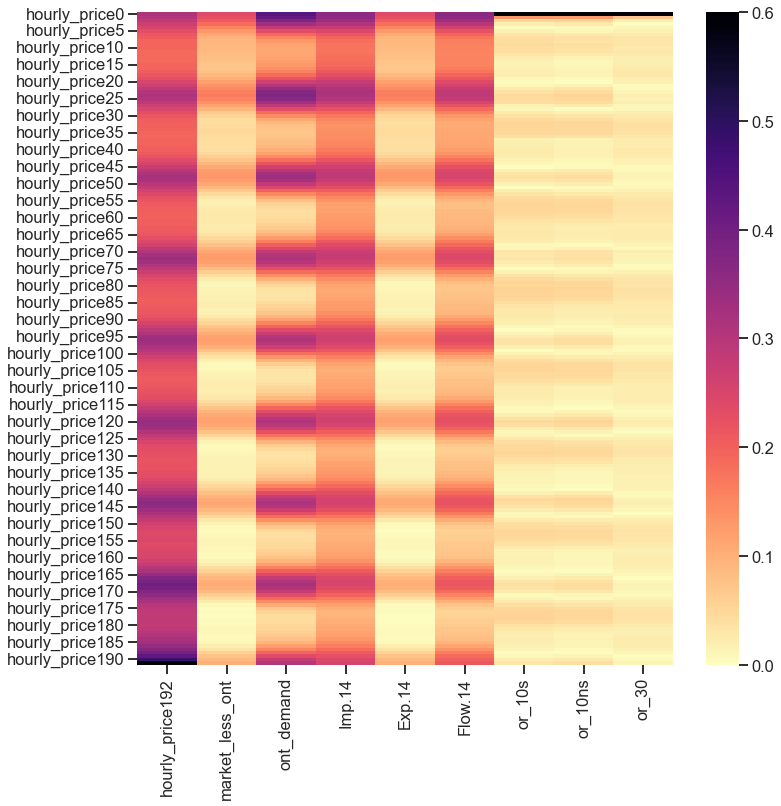

In [653]:
fig, ax = plt.subplots(figsize=(12,12))
# 8 days
sns.heatmap(np.abs(hours_ahead_corr.iloc[:192,192:]), ax=ax, cmap='magma_r', vmin=0, vmax=0.6)

differenced

<AxesSubplot:>

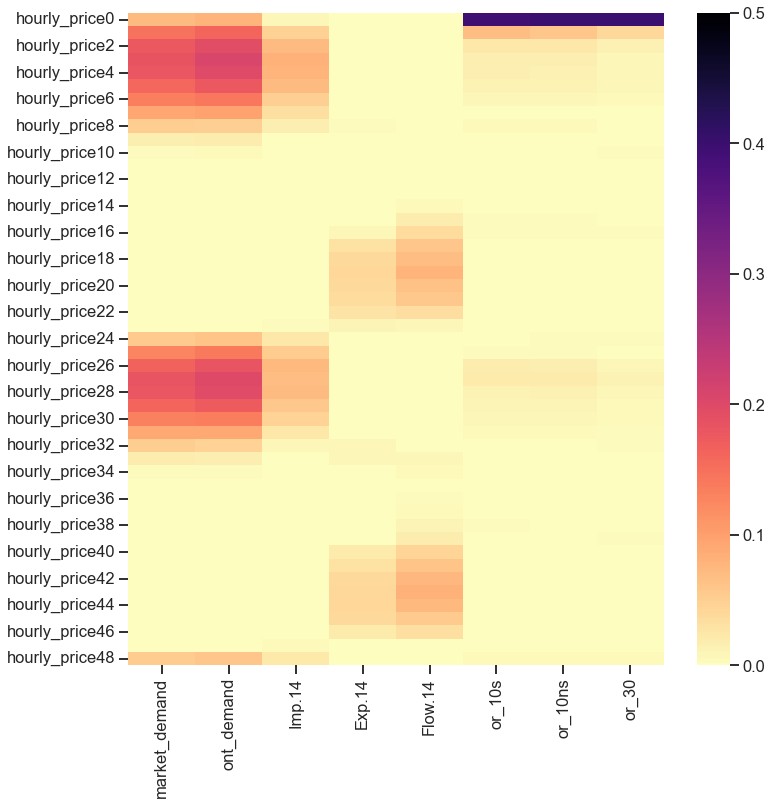

In [344]:
cols = ['market_demand','ont_demand','Imp.14', 'Exp.14', 'Flow.14','or_10s', 'or_10ns', 'or_30']
hours_ahead_corr = pd.concat([hrs_ahead, train_set[cols].diff(1)], axis=1)
hours_ahead_corr = hours_ahead_corr.corr()
fig, ax = plt.subplots(figsize=(12,12))

sns.heatmap(hours_ahead_corr.iloc[:49,49:], ax=ax, cmap='magma_r', vmin=0, vmax=0.5)

the reserve price the hour directly before is corrolated (maybe this will help us with spiking)

flow breakdown by location: some are specifically corrolated -> imp.14 (the sum of the other inputs), Flow1, various broken down inputs

<AxesSubplot:>

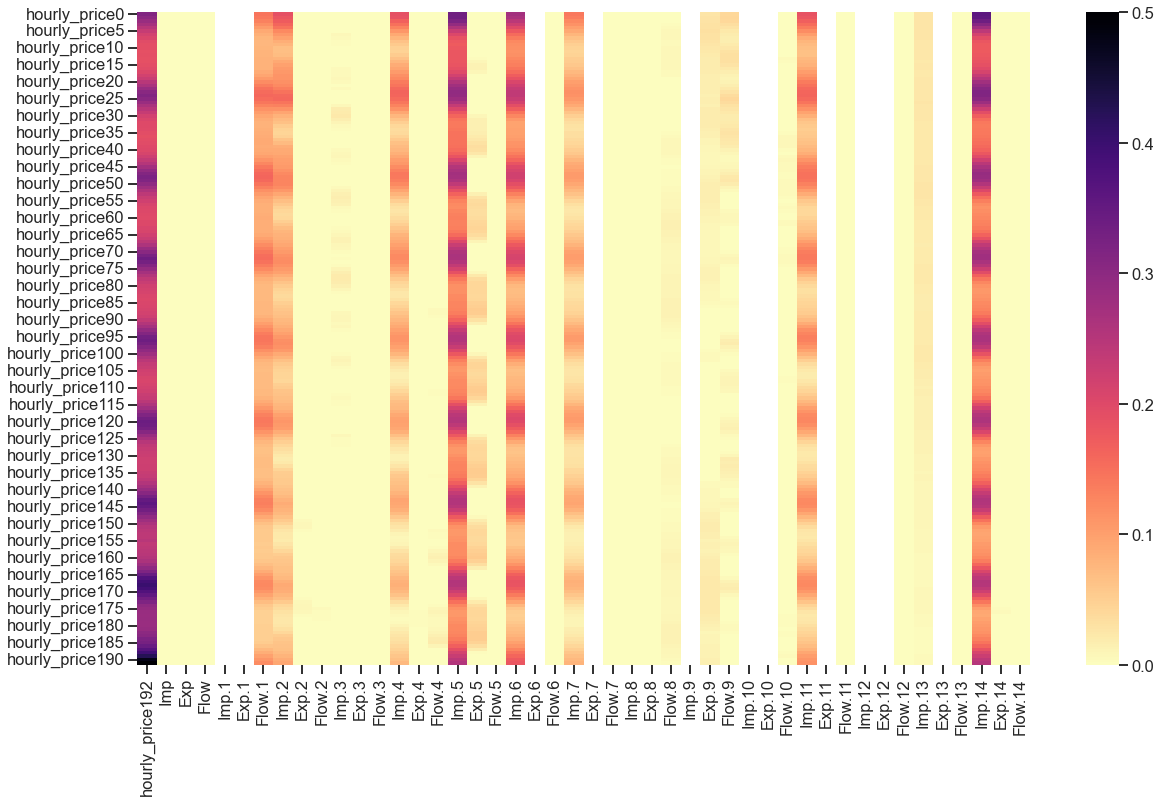

In [365]:
col='hourly_price'
shift_size=193
hrs_ahead = pd.concat([train_set[col].shift(-i) for i in range(shift_size)], axis=1)
hrs_ahead.columns = [col + str(j) for j in range(shift_size)]
hrs_ahead.head()

cols_flow = ['Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14',]

hours_ahead_corr_flow = pd.concat([hrs_ahead, train_set[cols_flow]], axis=1)
hours_ahead_corr_flow = hours_ahead_corr_flow.corr()
fig, ax = plt.subplots(figsize=(20,12))

sns.heatmap(hours_ahead_corr_flow.iloc[:192,192:], ax=ax, cmap='magma_r', vmin=0, vmax=0.5)

### other time-series features: entropy for example, moving avgs, slope

In [368]:
def entropy(X):
    number_of_values = list(set(X))
    N = len(X)
    p_s = 0
    for x in number_of_values:
        n_x = len(np.where(X==x)[0])
        p_x = n_x/N
        p_s = p_s + p_x*np.log(p_x)
    return -p_s

approximate entropy

In [435]:
def ApEn(U, m, r) -> float:
    """Approximate_entropy."""

    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])

    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [
            len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0)
            for x_i in x
        ]
        return (N - m + 1.0) ** (-1) * sum(np.log(C))

    N = len(U)

    return abs(_phi(m + 1) - _phi(m))

In [508]:
#train_minmax = (train_set['hourly_price']-train_set['hourly_price'].min())/(train_set['hourly_price'].max()-train_set['hourly_price'].min())
#train_set_daily = np.array_split(train_minmax, 1720)
train_set_daily = np.array_split(train_set['hourly_price'], 1720) # split into daily

In [502]:
approx_entropy_daily = [ApEn(t, 2, 3) for t in train_set_daily]

In [427]:
from scipy.stats.stats import pearsonr

c:\Users\Keagan Rankin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(-0.20434094566483235, 1.1642919429047547e-17)

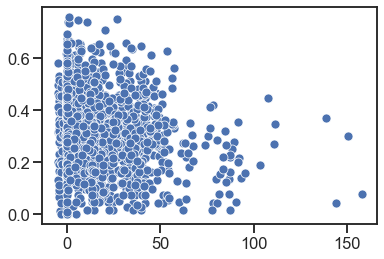

In [509]:
sns.scatterplot([t.iloc[0] for t in train_set_daily[1:]], y=approx_entropy_daily[:-1])
pearsonr([t.iloc[0] for t in train_set_daily[1:]], approx_entropy_daily[:-1])

avg gradient of last x hours (is it accelerating)?

In [492]:
train_set_daily = np.array_split(train_set['hourly_price'], 1720)
train_set_3_hours = np.array_split(train_set['hourly_price'], 13754) # length of train/3

three_hr_grad = [t.iloc[2] - t.iloc[0] for t in train_set_3_hours]
daily_hr_grad = [t.iloc[16] - t.iloc[0] for t in train_set_daily]

In [469]:
print(len(three_hr_grad))

13754


c:\Users\Keagan Rankin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\Keagan Rankin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


3 hr (0.18473735329334373, 7.589431248014877e-106)
day (0.12899533182816628, 8.014650274004836e-08)


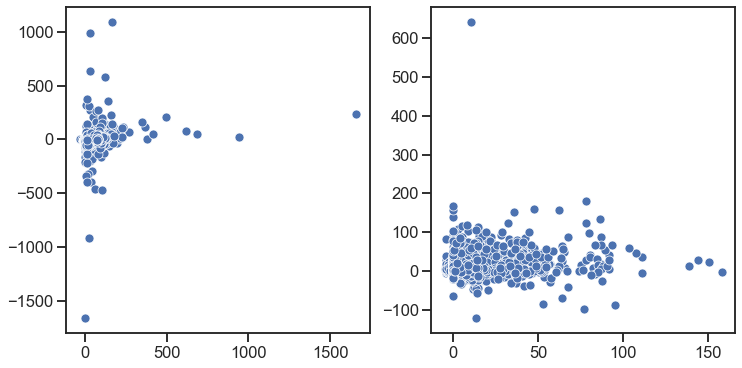

In [493]:
fig, ax = plt.subplots(1,2, figsize=(12,6))

sns.scatterplot([t.iloc[0] for t in train_set_3_hours[1:]], y=three_hr_grad[:-1], ax=ax[0])
print('3 hr', pearsonr([t.iloc[0] for t in train_set_3_hours[1:]], three_hr_grad[:-1]))

sns.scatterplot([t.iloc[0] for t in train_set_daily[1:]], y=daily_hr_grad[:-1], ax=ax[1])
print('day', pearsonr([t.iloc[0] for t in train_set_daily[1:]], daily_hr_grad[:-1]))

mean price 24-30 hours ago

## Weather features

### Weather imputation

In [269]:
print(train_set.shape)
train_set.iloc[:,52:].isnull().sum()

(41262, 65)


Year             0
Month            0
Day              0
max_t          408
min_t          432
mean_t         432
hdd            432
cdd            432
tot_rain       336
tot_snow       288
tot_precip     168
gust_dir      6720
gust_speed    5712
dtype: int64

In [255]:
from sklearn.impute import KNNImputer

In [607]:
def input_energyprice_data(data):
    """Imputting temp, CDD/HDD, precip, and wind data"""
    # Temperatures and HDD/CDD imputed using the median of the month
    data_c = data.copy()
    temp_fill_table = data_c.groupby('Month').median()[['max_t','min_t','mean_t','hdd','cdd']]
    for m in range(1,13):
        data_c.loc[data_c['Month'] == m] = data_c.loc[data_c['Month'] == m].fillna({'max_t': temp_fill_table.loc[m,'max_t'],
                                                                                    'min_t': temp_fill_table.loc[m,'min_t'],
                                                                                    'hdd': temp_fill_table.loc[m,'hdd'],
                                                                                    'cdd': temp_fill_table.loc[m,'cdd'],
                                                                                    'mean_t': temp_fill_table.loc[m,'mean_t']})
        
    # precipitation imputed assuming there is no precip on those days (analysis shows nothing particularly special; probably scheduled maintenance)
    data_c[['tot_rain','tot_snow','tot_precip']] = data_c[['tot_rain','tot_snow','tot_precip']].fillna(0)

    # there is no simple gust dir and speed imputation: use K-NN impute, take sqrt(N) for val of K
    knn_impute = KNNImputer(n_neighbors=int(np.sqrt(data_c.shape[0])))
    data_c_knn = knn_impute.fit_transform(data_c)
    data_c_knn = pd.DataFrame(columns=data_c.columns, index=data_c.index, data=data_c_knn)
        

    return data_c_knn

In [268]:
testr = input_energyprice_data(train_set)

(41262, 65)
Year          0
Month         0
Day           0
max_t         0
min_t         0
mean_t        0
hdd           0
cdd           0
tot_rain      0
tot_snow      0
tot_precip    0
gust_dir      0
gust_speed    0
dtype: int64


In [608]:
print(testr.shape)
print(testr.iloc[:,52:].isnull().sum())
testr

(41262, 65)
Year          0
Month         0
Day           0
max_t         0
min_t         0
mean_t        0
hdd           0
cdd           0
tot_rain      0
tot_snow      0
tot_precip    0
gust_dir      0
gust_speed    0
dtype: int64


,hourly_price,or_10s,or_10ns,or_30,Hour,market_demand,ont_demand,Imp,Exp,Flow,...,max_t,min_t,mean_t,hdd,cdd,tot_rain,tot_snow,tot_precip,gust_dir,gust_speed
2018-01-01 01:00:00,51.29,0.20,0.20,0.19,1.0,18974.0,16627.0,28.0,42.0,16.0,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 02:00:00,43.59,0.20,0.20,0.20,2.0,18447.0,16084.0,28.0,0.0,-20.0,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 03:00:00,93.60,0.25,0.25,0.22,3.0,18453.0,15866.0,28.0,0.0,-26.0,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 04:00:00,54.78,0.20,0.20,0.20,4.0,18662.0,15725.0,28.0,0.0,-36.0,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
2018-01-01 05:00:00,14.35,0.20,0.20,0.20,5.0,18060.0,15470.0,28.0,42.0,6.0,...,-8.7,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16 02:00:00,31.98,1.57,0.15,0.15,2.0,13788.0,12034.0,50.0,0.0,-47.0,...,24.7,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0
2022-09-16 03:00:00,14.37,1.61,0.15,0.15,3.0,13853.0,11896.0,50.0,0.0,-54.0,...,24.7,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0
2022-09-16 04:00:00,14.39,1.57,0.15,0.15,4.0,14112.0,12065.0,100.0,0.0,-89.0,...,24.7,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0
2022-09-16 05:00:00,23.35,1.13,0.15,0.15,5.0,13999.0,12169.0,100.0,0.0,-107.0,...,24.7,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0


### Feature eng weather

lagged weather vs. price naive

<AxesSubplot:>

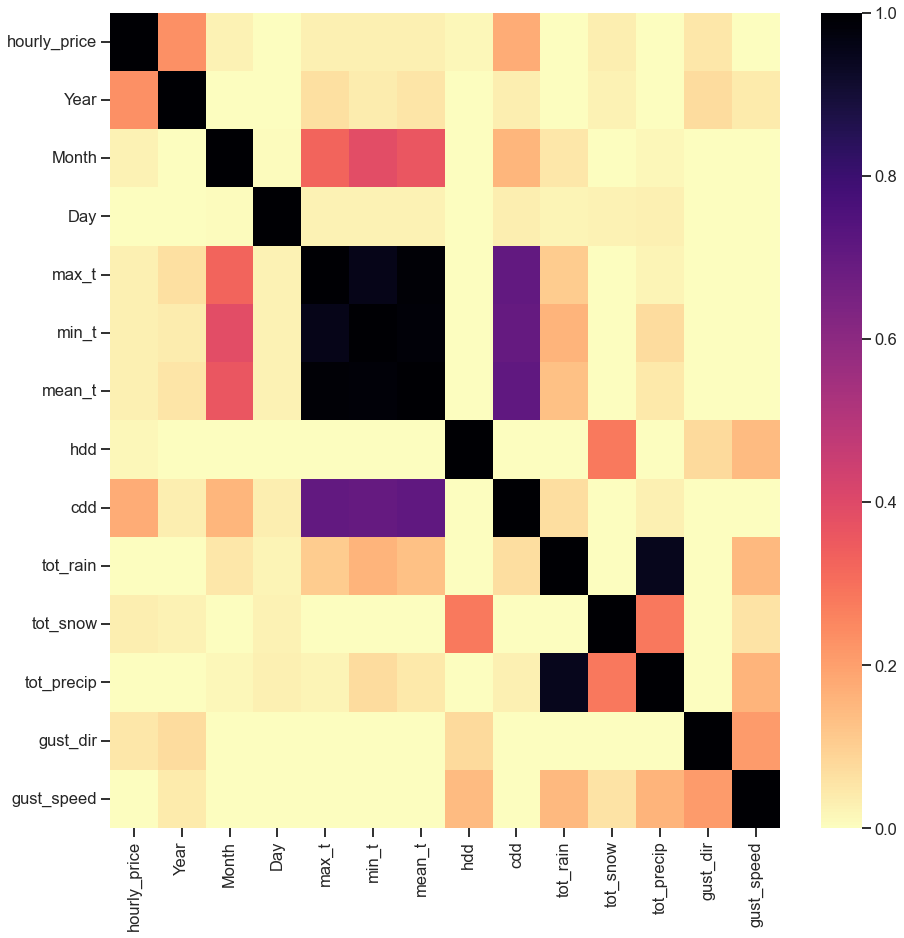

In [297]:
fig, ax = plt.subplots(figsize=(15,15))
tmap = testr[['max_t', 'min_t',
       'mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip',
       'gust_dir', 'gust_speed']]
sns.heatmap(pd.concat([testr[['hourly_price', 'Year', 'Month', 'Day']],
                       testr[['max_t', 'min_t','mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip','gust_dir', 'gust_speed']].shift(23)],axis=1).corr(), 
                       ax=ax, vmin=0, vmax=1, cmap='magma_r')

look at corro with six month or year or month etc.

In [341]:
col='hourly_price'
shift_sizes = [x*24-1 for x in range(1,366)]
hrs_ahead_weather = pd.concat([testr[col].shift(-i) for i in shift_sizes], axis=1)
hrs_ahead_weather.columns = [col + str((j+1)/24) for j in shift_sizes]
hrs_ahead_weather.head()

,hourly_price1.0,hourly_price2.0,hourly_price3.0,hourly_price4.0,hourly_price5.0,hourly_price6.0,hourly_price7.0,hourly_price8.0,hourly_price9.0,hourly_price10.0,...,hourly_price356.0,hourly_price357.0,hourly_price358.0,hourly_price359.0,hourly_price360.0,hourly_price361.0,hourly_price362.0,hourly_price363.0,hourly_price364.0,hourly_price365.0
2018-01-01 01:00:00,38.14,29.72,46.04,106.23,67.57,51.34,27.67,0.00,30.97,2.39,...,33.59,17.91,15.39,19.60,9.64,0.0,0.0,25.14,19.54,0.00
2018-01-01 02:00:00,31.12,2.31,15.77,18.50,42.71,48.40,0.00,4.77,6.57,0.00,...,24.84,29.26,14.35,19.76,8.10,0.0,0.0,56.26,20.44,0.00
2018-01-01 03:00:00,10.76,19.43,4.94,13.33,12.21,46.71,0.00,0.00,3.33,0.00,...,19.44,13.35,24.19,9.55,6.47,0.0,0.0,62.10,13.33,0.00
2018-01-01 04:00:00,14.34,0.00,6.47,13.36,13.32,37.49,0.00,0.00,0.00,0.00,...,25.70,13.33,14.39,9.49,9.31,0.0,0.0,29.30,13.35,-0.11
2018-01-01 05:00:00,0.29,0.00,0.75,13.34,13.36,25.74,0.00,1.11,3.32,0.00,...,26.72,13.32,14.39,11.35,0.00,0.0,0.0,25.34,28.51,-1.84


<AxesSubplot:>

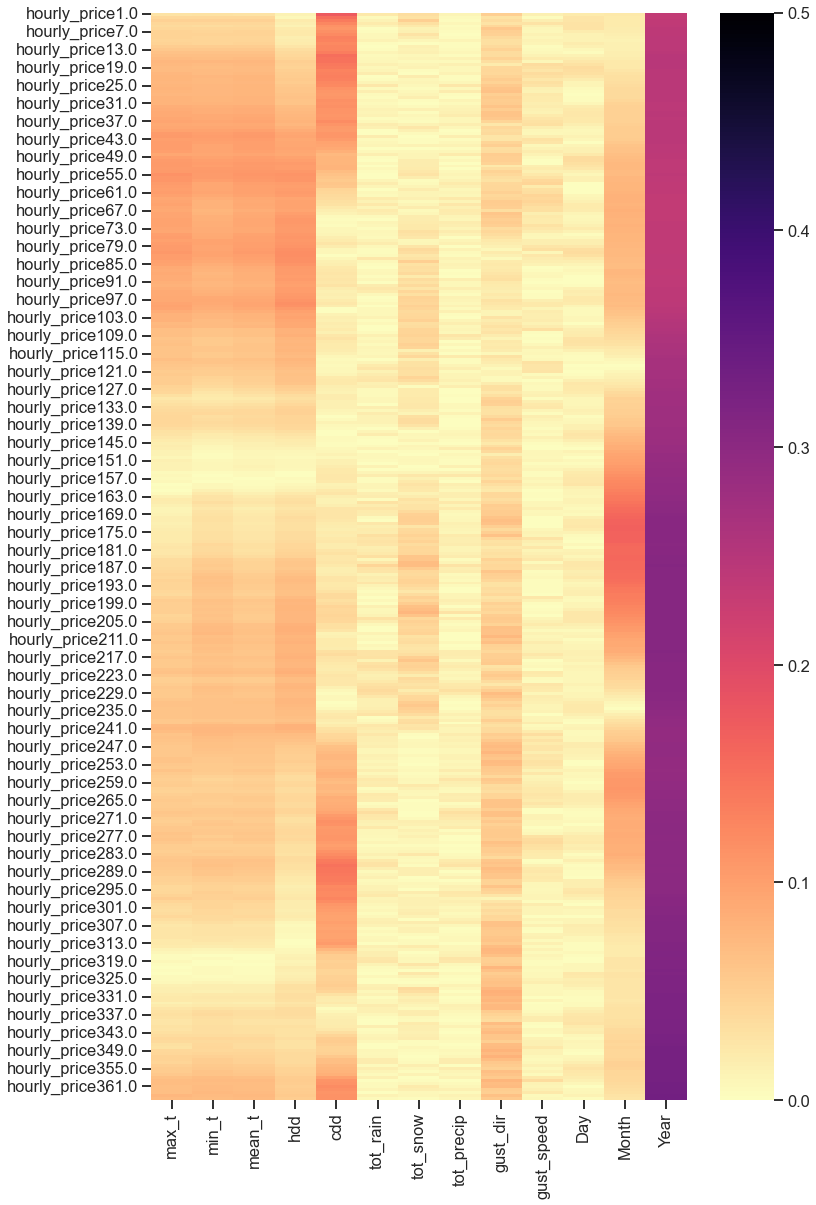

In [663]:
cols = ['max_t', 'min_t','mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip','gust_dir', 'gust_speed',
        'Day','Month','Year']
hours_ahead_corr_weather = pd.concat([hrs_ahead_weather, testr[cols]], axis=1)
hours_ahead_corr_weather = hours_ahead_corr_weather.corr()
fig, ax = plt.subplots(figsize=(12,20))

sns.heatmap(np.abs(hours_ahead_corr_weather.iloc[:365,365:]), ax=ax, cmap='magma_r', vmin=0, vmax=0.5)

From above:
- looks like hourly price is corrolated with temp (which we can dimension-reduce) for about 140 days prior.
- hdd corrolation ~160-300 days before
- cdd corrolation the last 60 days strongly and also 160-200 days interestingly
- rain not a good predictor but total snow 155-240 days is 
- just direction is corrolated the whole year 
<br> prob dim reduce all of these

In [343]:
testr['Day'].shift(-46)

2018-01-01 01:00:00    2.0
2018-01-01 02:00:00    3.0
2018-01-01 03:00:00    3.0
2018-01-01 04:00:00    3.0
2018-01-01 05:00:00    3.0
                      ... 
2022-09-16 02:00:00    NaN
2022-09-16 03:00:00    NaN
2022-09-16 04:00:00    NaN
2022-09-16 05:00:00    NaN
2022-09-16 06:00:00    NaN
Name: Day, Length: 41262, dtype: float64

foo_knn

In [243]:
#train_set[train_set['hourly_price'] > train_set['hourly_price'].quantile(0.999)]

## Other features

In [526]:
inflation_data = pd.read_csv('C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/inflation/inflation_ontario_power_index_monthly.csv', index_col=0, header=8).iloc[2:4].T
inflation_data.index = pd.DatetimeIndex(inflation_data.index)

In [530]:
inflation_data_hourly = inflation_data.resample('H').ffill()

In [542]:
train_and_inflation = pd.concat([train_set['hourly_price'],inflation_data_hourly], axis=1).loc[datetime(2018,1,1,1):datetime(2022,9,16,6)]
train_and_inflation

,hourly_price,Electric power selling price over 5000kw,Electric power selling price under 5000kw
2018-01-01 01:00:00,51.29,116.5,127.2
2018-01-01 02:00:00,43.59,116.5,127.2
2018-01-01 03:00:00,93.60,116.5,127.2
2018-01-01 04:00:00,54.78,116.5,127.2
2018-01-01 05:00:00,14.35,116.5,127.2
...,...,...,...
2022-09-16 02:00:00,31.98,111.3,111.5
2022-09-16 03:00:00,14.37,111.3,111.5
2022-09-16 04:00:00,14.39,111.3,111.5
2022-09-16 05:00:00,23.35,111.3,111.5


In [573]:
inflation_data_hourly_1monthshift = inflation_data.shift(1, freq='MS').resample('H').ffill()
inflation_data_hourly_1monthshift

month_offset = pd.concat([train_and_inflation['hourly_price'], inflation_data_hourly_1monthshift], axis=1).loc[datetime(2018,1,1,1):datetime(2022,9,16,6)]
month_offset['Electric power selling price over 5000kw'] = month_offset['Electric power selling price over 5000kw'].astype(float)
month_offset['Electric power selling price under 5000kw'] = month_offset['Electric power selling price under 5000kw'].astype(float)

over (0.040044220313952626, 7.406810629367037e-16)
under (-0.04339283858391883, 2.361531531422279e-18)


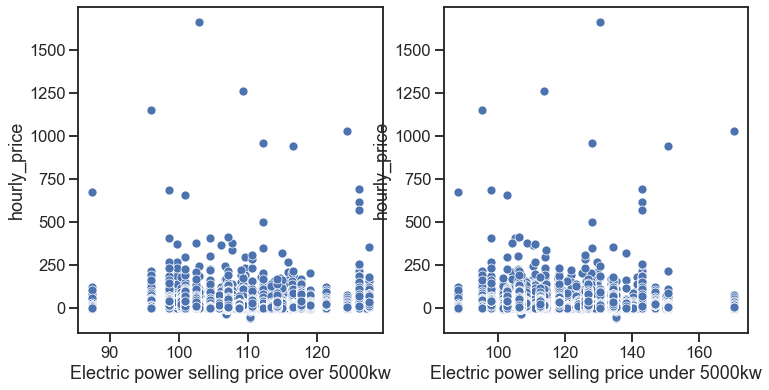

In [583]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.scatterplot(y=month_offset['hourly_price'], x=month_offset['Electric power selling price over 5000kw'],ax=ax[0])
sns.scatterplot(y=month_offset['hourly_price'], x=month_offset['Electric power selling price under 5000kw'],ax=ax[1])

month_offset_nas = month_offset.dropna()
print('over', pearsonr(month_offset_nas['hourly_price'].dropna(), month_offset_nas['Electric power selling price over 5000kw'].dropna()))
print('under', pearsonr(month_offset_nas['hourly_price'].dropna(), month_offset_nas['Electric power selling price under 5000kw'].dropna()))

In [549]:
train_set.loc[datetime(2018,1,31,1):]

,hourly_price,or_10s,or_10ns,or_30,Hour,market_demand,ont_demand,Imp,Exp,Flow,...,min_t,mean_t,hdd,cdd,tot_rain,tot_snow,tot_precip,gust_dir,gust_speed,market_less_ont
2018-01-01 01:00:00,51.29,0.20,0.20,0.19,1,18974,16627,28,42,16,...,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0,2347
2018-01-01 02:00:00,43.59,0.20,0.20,0.20,2,18447,16084,28,0,-20,...,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0,2363
2018-01-01 03:00:00,93.60,0.25,0.25,0.22,3,18453,15866,28,0,-26,...,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0,2587
2018-01-01 04:00:00,54.78,0.20,0.20,0.20,4,18662,15725,28,0,-36,...,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0,2937
2018-01-01 05:00:00,14.35,0.20,0.20,0.20,5,18060,15470,28,42,6,...,-21.3,-15.0,33.0,0.0,0.0,0.0,0.0,28.0,54.0,2590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-16 02:00:00,31.98,1.57,0.15,0.15,2,13788,12034,50,0,-47,...,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0,1754
2022-09-16 03:00:00,14.37,1.61,0.15,0.15,3,13853,11896,50,0,-54,...,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0,1957
2022-09-16 04:00:00,14.39,1.57,0.15,0.15,4,14112,12065,100,0,-89,...,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0,2047
2022-09-16 05:00:00,23.35,1.13,0.15,0.15,5,13999,12169,100,0,-107,...,11.7,18.2,0.0,0.2,0.0,0.0,0.0,9.0,31.0,1830


## Dim reduction

In [584]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [694]:
# exclude total columns at end
fscaled = StandardScaler().fit_transform(testr[['min_t','mean_t','max_t']])
pca = PCA()
f_pcs = pca.fit_transform(fscaled)

# Store
cols= ['pc{}'.format(i) for i in range(1,fscaled.shape[1]+1)]
f_pcs_df = pd.DataFrame(data=f_pcs,
                            columns=cols, index=testr.index)

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

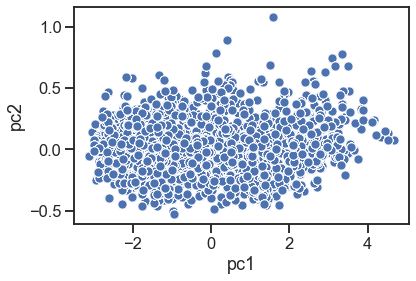

In [695]:
sns.scatterplot(data=f_pcs_df, x='pc1', y='pc2')

In [696]:
f_pcs_df

,pc1,pc2,pc3
2018-01-01 01:00:00,3.894579,0.399920,0.002565
2018-01-01 02:00:00,3.894579,0.399920,0.002565
2018-01-01 03:00:00,3.894579,0.399920,0.002565
2018-01-01 04:00:00,3.894579,0.399920,0.002565
2018-01-01 05:00:00,3.894579,0.399920,0.002565
...,...,...,...
2022-09-16 02:00:00,-1.380098,0.185821,-0.001792
2022-09-16 03:00:00,-1.380098,0.185821,-0.001792
2022-09-16 04:00:00,-1.380098,0.185821,-0.001792
2022-09-16 05:00:00,-1.380098,0.185821,-0.001792


[0.88466795 0.98839147 0.99998771 1.        ]


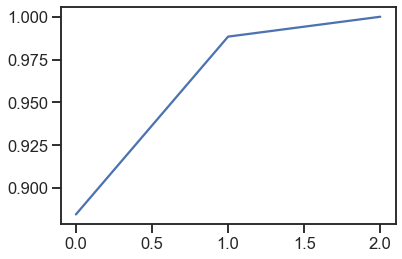

In [601]:
variance = pca.explained_variance_ratio_.cumsum()
print(variance)
plt.plot(np.arange(0,3), variance[:3])

## Final feature collection and simple model CV
- 1: the lagged price up to 5 hours before (5 features)
- 2: the average of the 23x, 24x, 25x lagged price for the last 7 days
- 1 and 2 for demand 
- 1 and 2 for Flow.1
- 1 and 2 for input sum (input.14)
- the reserve prices from the previous hour
- previous day price approximate entropy
- potentially the 3-hr gradient
- PC1 of the dim reduced temps (min max mean) of the previous three months (1 feature each) (CDD and HDD are derived from these so redundant)
- past week mean temp
- yesterdays temp
- yesterday's gust direction
- month of year

In [610]:
train_set_f = input_energyprice_data(train_set)

In [654]:
train_set_f.columns

Index(['hourly_price', 'or_10s', 'or_10ns', 'or_30', 'Hour', 'market_demand',
       'ont_demand', 'Imp', 'Exp', 'Flow', 'Imp.1', 'Exp.1', 'Flow.1', 'Imp.2',
       'Exp.2', 'Flow.2', 'Imp.3', 'Exp.3', 'Flow.3', 'Imp.4', 'Exp.4',
       'Flow.4', 'Imp.5', 'Exp.5', 'Flow.5', 'Imp.6', 'Exp.6', 'Flow.6',
       'Imp.7', 'Exp.7', 'Flow.7', 'Imp.8', 'Exp.8', 'Flow.8', 'Imp.9',
       'Exp.9', 'Flow.9', 'Imp.10', 'Exp.10', 'Flow.10', 'Imp.11', 'Exp.11',
       'Flow.11', 'Imp.12', 'Exp.12', 'Flow.12', 'Imp.13', 'Exp.13', 'Flow.13',
       'Imp.14', 'Exp.14', 'Flow.14', 'Year', 'Month', 'Day', 'max_t', 'min_t',
       'mean_t', 'hdd', 'cdd', 'tot_rain', 'tot_snow', 'tot_precip',
       'gust_dir', 'gust_speed', 'market_less_ont'],
      dtype='object')

In [1617]:
target = train_set_f['hourly_price']

# PRICE FEATURES
# lagged price up to 5 hours
price_lag = pd.concat([train_set_f['hourly_price'].shift(i) for i in range(1,25)], axis=1)
price_lag.columns = ['price_lag_'+str(i) for i in range(1,25)]

# grad last hour
grad_ran = [1,2,3,4,5,6]
price_grad = pd.concat([train_set_f['hourly_price'].shift(i) for i in grad_ran], axis=1)
price_grad.columns = ['price_grad_'+str(i) for i in grad_ran]
price_grad['pgrad_12'] = pd.DataFrame(price_grad['price_grad_1'] - price_grad['price_grad_2'])
price_grad['pgrad_23'] = pd.DataFrame(price_grad['price_grad_2'] - price_grad['price_grad_3'])
price_grad['pgrad_34'] = pd.DataFrame(price_grad['price_grad_3'] - price_grad['price_grad_4'])
price_grad['pgrad_45'] = pd.DataFrame(price_grad['price_grad_4'] - price_grad['price_grad_5'])
price_grad['pgrad_56'] = pd.DataFrame(price_grad['price_grad_5'] - price_grad['price_grad_6'])
#price_grad = price_grad.rename(columns={0:'price_grad_1_hr'})
price_grad = price_grad.drop(['price_grad_'+str(i) for i in grad_ran], axis=1)


lag_groups = [[23,24,25],[47,48,49],[71,72,73],[95,96,97],[119,120,121],[143,144,145],[167,168,169]]
# 23, 24, 25 hour lagged price for the last 7 days
price_lag_mean_7_day_23 = pd.concat([train_set_f['hourly_price'].shift(23+24*i) for i in range(7)], axis=1).mean(axis=1)
price_lag_mean_7_day_23.name = 'seven_day_23'
price_lag_mean_7_day_24 = pd.concat([train_set_f['hourly_price'].shift(24+24*i) for i in range(7)], axis=1).mean(axis=1)
price_lag_mean_7_day_24.name = 'seven_day_24'
price_lag_mean_7_day_25 = pd.concat([train_set_f['hourly_price'].shift(25+24*i) for i in range(7)], axis=1).mean(axis=1)
price_lag_mean_7_day_25.name = 'seven_day_25'

# this method works better but drops more data
price_lag_mean_7_days = []
for l in lag_groups:
    price_lag_n = pd.concat([train_set_f['hourly_price'].shift(i) for i in l], axis=1).mean(axis=1)
    price_lag_mean_7_days.append(price_lag_n)
price_lag_mean_7_days= pd.concat(price_lag_mean_7_days, axis=1)
price_lag_mean_7_days.columns = ['price_sd_lag'+str(i) for i in range(1,8)]

# lagged demand features
demand_lag = pd.concat([train_set_f['market_demand'].shift(i) for i in range(0,25)], axis=1)
demand_lag.columns = ['demand_lag_'+str(i) for i in range(0,25)]

demand_lag_mean_7_day_23 = pd.concat([train_set_f['market_demand'].shift(23+24*i) for i in range(7)], axis=1).mean(axis=1)
demand_lag_mean_7_day_23.name = 'demand_seven_day_23'
demand_lag_mean_7_day_24 = pd.concat([train_set_f['market_demand'].shift(24+24*i) for i in range(7)], axis=1).mean(axis=1)
demand_lag_mean_7_day_24.name = 'demand_seven_day_24'
demand_lag_mean_7_day_25 = pd.concat([train_set_f['market_demand'].shift(25+24*i) for i in range(7)], axis=1).mean(axis=1)
demand_lag_mean_7_day_25.name = 'demand_seven_day_25'

demand_lag_mean_7_days = []
for l in lag_groups:
    demand_lag_n = pd.concat([train_set_f['market_demand'].shift(i) for i in l], axis=1).mean(axis=1)
    demand_lag_mean_7_days.append(demand_lag_n)
demand_lag_mean_7_days= pd.concat(demand_lag_mean_7_days, axis=1)
demand_lag_mean_7_days.columns = ['demand_sd_lag'+str(i) for i in range(1,8)]


# lagged flow 1 features
flow_lag = pd.concat([train_set_f['Flow.1'].shift(i) for i in range(1,6)], axis=1)
flow_lag.columns = ['flow_lag_'+str(i) for i in range(1,6)]

flow_lag_mean_7_day_23 = pd.concat([train_set_f['Flow.1'].shift(23+24*i) for i in range(7)], axis=1).mean(axis=1)
flow_lag_mean_7_day_23.name = 'flow_seven_day_23'
flow_lag_mean_7_day_24 = pd.concat([train_set_f['Flow.1'].shift(24+24*i) for i in range(7)], axis=1).mean(axis=1)
flow_lag_mean_7_day_24.name = 'flow_seven_day_24'
flow_lag_mean_7_day_25 = pd.concat([train_set_f['Flow.1'].shift(25+24*i) for i in range(7)], axis=1).mean(axis=1)
flow_lag_mean_7_day_25.name = 'flow_seven_day_25'

# lagged imports 14 features: IMPORTS ARE SCHEDULED AN HOUR AHEAD AHA SO WE CAN USE THE CURRENT HOUR VALUE file:///C:/Users/Keagan%20Rankin/Downloads/WB-Intro-Ontario-Physical-Markets.pdf
input_lag = pd.concat([train_set_f['Imp.14'].shift(i) for i in range(0,6)], axis=1)
input_lag.columns = ['imp_lag_'+str(i) for i in range(0,6)]

input_lag_mean_7_day_23 = pd.concat([train_set_f['Imp.14'].shift(23+24*i) for i in range(7)], axis=1).mean(axis=1)
input_lag_mean_7_day_23.name = 'imp_seven_day_23'
input_lag_mean_7_day_24 = pd.concat([train_set_f['Imp.14'].shift(24+24*i) for i in range(7)], axis=1).mean(axis=1)
input_lag_mean_7_day_24.name = 'imp_seven_day_24'
input_lag_mean_7_day_25 = pd.concat([train_set_f['Imp.14'].shift(25+24*i) for i in range(7)], axis=1).mean(axis=1)
input_lag_mean_7_day_25.name = 'imp_seven_day_25'

# previous hour reserve
reserve_lag = train_set_f[['or_10s','or_10ns','or_30']].shift(1)
reserve_lag.columns = ['reserve_10_lag','reserve_n_10_lag','reserve_30_lag']

# temperature embedding
# exclude total columns at end
fscaled = StandardScaler().fit_transform(train_set_f[['min_t','mean_t','max_t']])
pca = PCA()
f_pcs = pca.fit_transform(fscaled)
cols= ['pc{}'.format(i) for i in range(1,fscaled.shape[1]+1)]
f_pcs_df = pd.DataFrame(data=f_pcs, columns=cols, index=testr.index)
f_pcs_df = f_pcs_df['pc1']
temp_lag_week_mean = pd.DataFrame(pd.concat([f_pcs_df.shift(i) for i in range(24,731)], axis=1).mean(axis=1)) #169 vs. 731 a week vs. a month
temp_lag_week_mean = temp_lag_week_mean.rename(columns={0:'time_lag_prev_day'})

# yesterday's gust dir
gust_lag = train_set_f['gust_dir'].shift(1)

# cooling degree days
cooling_days = pd.DataFrame(train_set_f['cdd'].shift(1))
cooling_days = cooling_days.rename(columns={0:'cdd_1'})

# ramping
ramp = pd.concat([np.abs(train_set_f['Imp.14']-train_set_f['Exp.14']).shift(1),
                     np.abs(train_set_f['Imp.14']-train_set_f['Exp.14']).shift(0)],axis=1)
ramp['ramp'] = ramp[0]-ramp[1]
ramp = ramp.drop([0,1],axis=1)


# month and day
month_feat = train_set_f[['Year','Month','Day']]

In [1069]:
# approximate entropy feature
price_lag_one_day = pd.concat([train_set_f['hourly_price'].shift(i) for i in range(1,25)], axis=1)
approx_entropy_daily = price_lag_one_day.apply(lambda x: ApEn(x,2,3), axis=1)

C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_13176\2487781306.py:13: RuntimeWarning: divide by zero encountered in log
  return (N - m + 1.0) ** (-1) * sum(np.log(C))
C:\Users\Keagan Rankin\AppData\Local\Temp\ipykernel_13176\2487781306.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return abs(_phi(m + 1) - _phi(m))


In [1296]:
approx_entropy_daily = approx_entropy_daily.replace([np.inf, -np.inf], np.nan)
approx_entropy_daily = pd.DataFrame(approx_entropy_daily)
approx_entropy_daily = approx_entropy_daily.rename(columns={0:'approx_entropy_past_day'})

dataframe with all candidate features

In [1618]:
train_feat_eng = pd.concat([target, 
                            price_lag,
                            price_grad,
                            #price_lag_mean_7_day_23, price_lag_mean_7_day_24, price_lag_mean_7_day_25,
                            price_lag_mean_7_days,
                            demand_lag, 
                            #demand_lag_mean_7_day_23, demand_lag_mean_7_day_24, demand_lag_mean_7_day_25,
                            demand_lag_mean_7_days,
                            flow_lag, flow_lag_mean_7_day_23, flow_lag_mean_7_day_24, flow_lag_mean_7_day_25,
                            input_lag, input_lag_mean_7_day_23, input_lag_mean_7_day_24, input_lag_mean_7_day_25,
                            reserve_lag,
                            approx_entropy_daily,
                            temp_lag_week_mean,
                            gust_lag,
                            cooling_days,
                            ramp,
                            month_feat,
                            ],axis=1).dropna()

## init model test
try a basic lin regress

In [1392]:
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error

In [1619]:
print(train_feat_eng.shape)
print(train_feat_eng.columns)

(41095, 97)
Index(['hourly_price', 'price_lag_1', 'price_lag_2', 'price_lag_3',
       'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7',
       'price_lag_8', 'price_lag_9', 'price_lag_10', 'price_lag_11',
       'price_lag_12', 'price_lag_13', 'price_lag_14', 'price_lag_15',
       'price_lag_16', 'price_lag_17', 'price_lag_18', 'price_lag_19',
       'price_lag_20', 'price_lag_21', 'price_lag_22', 'price_lag_23',
       'price_lag_24', 'pgrad_12', 'pgrad_23', 'pgrad_34', 'pgrad_45',
       'pgrad_56', 'price_sd_lag1', 'price_sd_lag2', 'price_sd_lag3',
       'price_sd_lag4', 'price_sd_lag5', 'price_sd_lag6', 'price_sd_lag7',
       'demand_lag_0', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3',
       'demand_lag_4', 'demand_lag_5', 'demand_lag_6', 'demand_lag_7',
       'demand_lag_8', 'demand_lag_9', 'demand_lag_10', 'demand_lag_11',
       'demand_lag_12', 'demand_lag_13', 'demand_lag_14', 'demand_lag_15',
       'demand_lag_16', 'demand_lag_17', 'demand_lag_18', 'demand

Note that this model only does 1-step ahead forecasting

In [1610]:
# choose the features to use
lin_model_features = ['price_lag_24','demand_lag_1','imp_lag_0','Month','reserve_30_lag','price_sd_lag2','price_sd_lag3','price_sd_lag4']

In [1652]:
lin_model = linear_model.LinearRegression()
reg_model = linear_model.Lasso(alpha=1)

# 80% = 32989 but 2022 power prices are completely different from previous years so mess with train_test set
t_size = 20000
# limit the amount ahead max 41262
limitr = 21000
y = np.array(train_feat_eng['hourly_price'].iloc[:t_size]).squeeze()
X = train_feat_eng[lin_model_features].iloc[:t_size]

y_test = np.array(train_feat_eng['hourly_price'].iloc[t_size:limitr])
X_test = train_feat_eng[lin_model_features].iloc[t_size:limitr]

print(X.shape)
print(y.shape)
lin_model.fit(X, y)
reg_model.fit(X,y)

#y_pred = lin_model.predict(X_test)
y_pred = reg_model.predict(X_test)

# res
print("Coefficients: \n", lin_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

(20000, 8)
(20000,)
Coefficients: 
 [0.09595616 0.00214608 0.00641271 0.29878064 0.09017232 0.08468374
 0.06561279 0.07654635]
Mean squared error: 216.50
Coefficient of determination: 0.07


2022 is a weird year for generation btw. You can see below is has significantly higher prices

(0.0, 250.0)

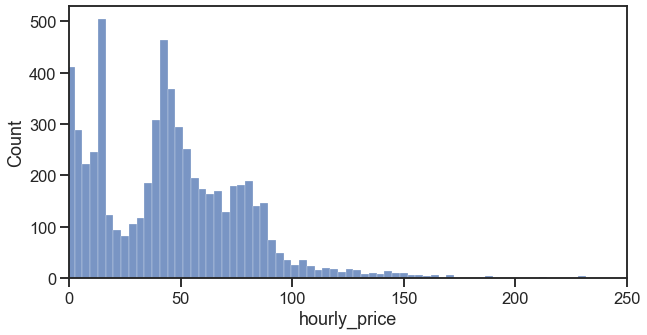

In [1653]:
fig, ax = plt.subplots(figsize=(10,5))
yeary=2022
sns.histplot(train_feat_eng['hourly_price'][datetime(yeary,1,1):datetime(yeary,1,1)+timedelta(days=365)], bins=200, ax=ax)
ax.set_xlim(0,250)

In [1600]:
# RANDOM WALK
print("Mean squared error: %.2f" % mean_squared_error(y_test[:-1], y_test[1:]))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test[:-1], y_test[1:]))

Mean squared error: 169.91
Coefficient of determination: 0.21


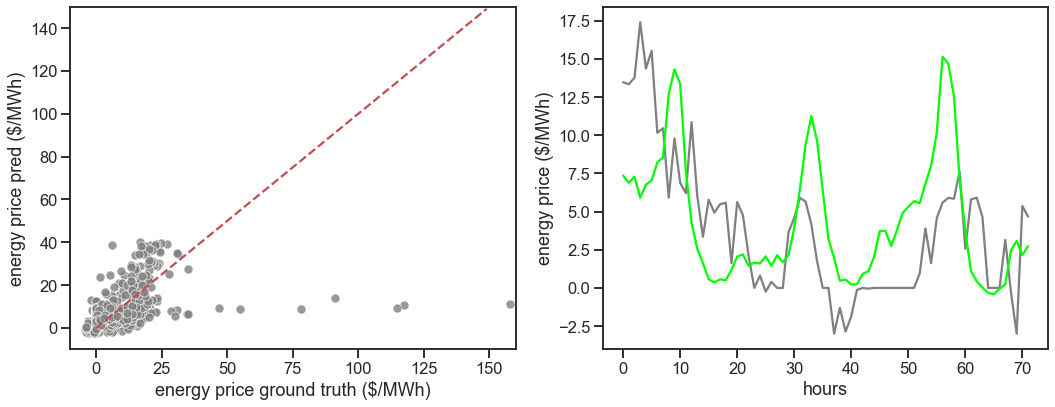

In [1654]:
y_test_plot = y_test
y_pred_plot = y_pred

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(x=y_test_plot, y=y_pred_plot, ax=ax[0], alpha=0.8, color='grey')

n_ahead = 172
jump = 100
sns.lineplot(x=np.arange(n_ahead-jump), y=y_test_plot[jump:n_ahead], ax=ax[1],
             color='grey')
sns.lineplot(x=np.arange(n_ahead-jump), y=y_pred_plot[jump:n_ahead], ax=ax[1],
             color='lime')


ax[0].set_xlabel('energy price ground truth ($/MWh)')
ax[0].set_ylabel('energy price pred ($/MWh)')
ax[0].set_xlim([-10,160])
ax[0].set_ylim([-10,150])
sns.lineplot(ax=ax[0], x=np.arange(150), y=np.arange(150), linestyle='--', color='r')

ax[1].set_xlabel('hours')
ax[1].set_ylabel('energy price ($/MWh)')

plt.tight_layout()

conclusion: price lag features increase r2 but really just seem to be lagging overwhelming the prediction with a lagged time series, so not great for prediction (mean error is 24$). We can probably improce with a diff model or by changing this into something more subtle (e.g. the slope of the line over the last x hours) <br>
other feature ideas:
- holiday
- weekend
- https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html
- IDEA FROM JEFF: add as feature the input output ramping (it predicts price spikes): abs(import - export) between coming hour and prev hour
- gradient of gradient (curvature/concavity)
- use demand projection

### Demand Model
A model trying to predict demand

In [1627]:
print(train_feat_eng.shape)
print(train_feat_eng.columns)

(41095, 97)
Index(['hourly_price', 'price_lag_1', 'price_lag_2', 'price_lag_3',
       'price_lag_4', 'price_lag_5', 'price_lag_6', 'price_lag_7',
       'price_lag_8', 'price_lag_9', 'price_lag_10', 'price_lag_11',
       'price_lag_12', 'price_lag_13', 'price_lag_14', 'price_lag_15',
       'price_lag_16', 'price_lag_17', 'price_lag_18', 'price_lag_19',
       'price_lag_20', 'price_lag_21', 'price_lag_22', 'price_lag_23',
       'price_lag_24', 'pgrad_12', 'pgrad_23', 'pgrad_34', 'pgrad_45',
       'pgrad_56', 'price_sd_lag1', 'price_sd_lag2', 'price_sd_lag3',
       'price_sd_lag4', 'price_sd_lag5', 'price_sd_lag6', 'price_sd_lag7',
       'demand_lag_0', 'demand_lag_1', 'demand_lag_2', 'demand_lag_3',
       'demand_lag_4', 'demand_lag_5', 'demand_lag_6', 'demand_lag_7',
       'demand_lag_8', 'demand_lag_9', 'demand_lag_10', 'demand_lag_11',
       'demand_lag_12', 'demand_lag_13', 'demand_lag_14', 'demand_lag_15',
       'demand_lag_16', 'demand_lag_17', 'demand_lag_18', 'demand

In [1680]:
dim_model_features = ['price_lag_1','price_lag_24','imp_lag_0','imp_seven_day_24','Month','reserve_10_lag',
                      'demand_lag_24','demand_sd_lag2','demand_sd_lag3','demand_sd_lag4',
                      'cdd','gust_dir','time_lag_prev_day']

lin_model = linear_model.LinearRegression()
reg_model = linear_model.Ridge(alpha=0.1)

# 80% = 32989 but 2022 power prices are completely different from previous years so mess with train_test set
t_size = 32989
# limit the amount ahead
limitr = 41263
y = np.array(train_feat_eng['demand_lag_0'].iloc[:t_size]).squeeze()
X = train_feat_eng[dim_model_features].iloc[:t_size]

y_test = np.array(train_feat_eng['demand_lag_0'].iloc[t_size:limitr])
X_test = train_feat_eng[dim_model_features].iloc[t_size:limitr]

print(X.shape)
print(y.shape)
lin_model.fit(X, y)
reg_model.fit(X,y)

#y_pred = lin_model.predict(X_test)
y_pred = reg_model.predict(X_test)

# res
print("Coefficients: \n", lin_model.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

(32989, 13)
(32989,)
Coefficients: 
 [ 2.89956317e+00 -1.09590440e+00  5.90299403e-01 -3.59622917e-01
  2.45892924e+01  8.99682246e-01  6.91892942e-01 -1.05875144e-01
  1.22197565e-01  1.09874044e-01  1.76412783e+02 -7.60571501e+00
  2.07633087e+02]
Mean squared error: 869451.37
Coefficient of determination: 0.83


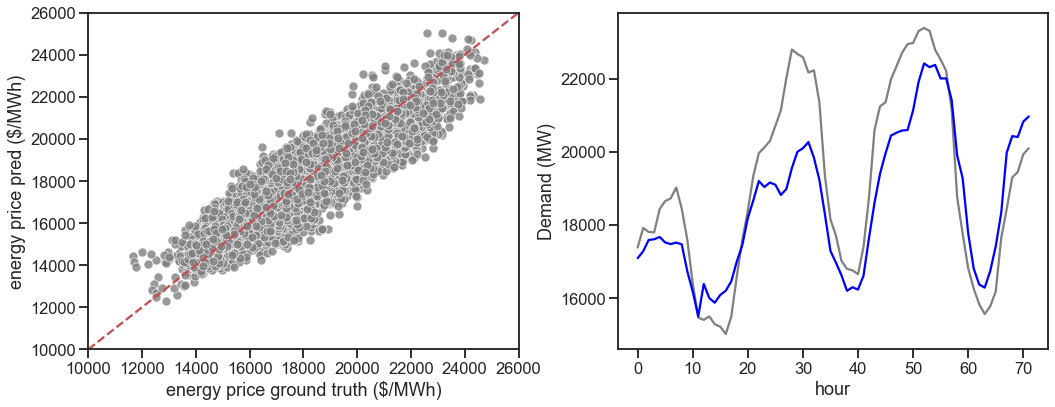

In [1686]:
y_test_plot = y_test
y_pred_plot = y_pred

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(x=y_test_plot, y=y_pred_plot, ax=ax[0], alpha=0.8, color='grey')

n_ahead = 6072
jump = 6000
sns.lineplot(x=np.arange(n_ahead-jump), y=y_test_plot[jump:n_ahead], ax=ax[1],
             color='grey')
sns.lineplot(x=np.arange(n_ahead-jump), y=y_pred_plot[jump:n_ahead], ax=ax[1],
             color='blue')


ax[0].set_xlabel('energy price ground truth ($/MWh)')
ax[0].set_ylabel('energy price pred ($/MWh)')
ax[0].set_xlim([10000,26000])
ax[0].set_ylim([10000,26000])
sns.lineplot(ax=ax[0], x=np.arange(10000,26000), y=np.arange(10000,26000), linestyle='--', color='r')

ax[1].set_xlabel('hour')
ax[1].set_ylabel('Demand (MW)')

plt.tight_layout()

------------------------------------------------------------------------------------
## Compare to the 1-forward Ontario model

In [1197]:
price = []
for x in range(2018,2024):
    #print(x)
    
    price_x = pd.read_csv('C:/mie1628_big_data/assignment_5/cloud_ml_proj/data/price_data_y/PUB_PriceHOEPPredispOR_{}.csv'.format(x), header=3, index_col=0)   
    price_x.index = pd.DatetimeIndex(price_x.index) + pd.to_timedelta(price_x['Hour'], unit='h')
    price.append(price_x)

price_t = pd.concat(price)
print(price_t.shape)
price_t.head()

(51576, 8)


,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
2018-01-01 01:00:00,1,51.29,40.62,35.50,40.32,0.20,0.20,0.19
2018-01-01 02:00:00,2,43.59,40.93,40.57,30.22,0.20,0.20,0.20
2018-01-01 03:00:00,3,93.60,49.84,45.30,40.20,0.25,0.25,0.22
2018-01-01 04:00:00,4,54.78,55.60,40.04,45.30,0.20,0.20,0.20
2018-01-01 05:00:00,5,14.35,40.04,34.80,47.47,0.20,0.20,0.20


In [1352]:
price_compare = price_t[datetime(2021,10,13,13):datetime(2022,9,16,6)].dropna()
price_compare
# INFORMATION LEAKAGE:
print("Mean squared error: %.2f" % mean_squared_error(price_compare['HOEP'], price_compare['Hour 3 Predispatch']))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(price_compare['HOEP'], price_compare['Hour 3 Predispatch']))

Mean squared error: 964.81
Coefficient of determination: 0.19


In [1203]:
print(y_test[:5])
price_compare.head()

[54.88 56.2  55.34 51.08 62.32]


,Hour,HOEP,Hour 1 Predispatch,Hour 2 Predispatch,Hour 3 Predispatch,OR 10 Min Sync,OR 10 Min non-sync,OR 30 Min
2021-10-13 13:00:00,13,54.88,70.00,70.00,80.00,5.17,3.47,3.47
2021-10-13 14:00:00,14,56.20,57.27,60.00,68.00,6.26,4.15,4.15
2021-10-13 15:00:00,15,55.34,60.00,60.00,68.00,5.76,5.76,5.76
2021-10-13 16:00:00,16,51.08,62.32,62.91,70.00,1.12,0.24,0.20
2021-10-13 17:00:00,17,62.32,65.00,65.00,69.12,12.69,12.69,3.58


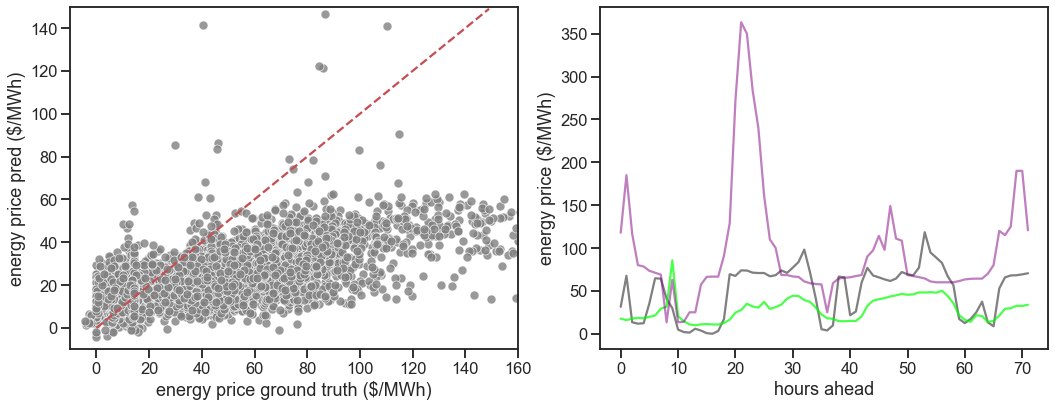

In [1361]:
y_test_plot = y_test
y_pred_plot = y_pred

fig, ax = plt.subplots(1,2, figsize=(15,6))
sns.scatterplot(x=y_test_plot, y=y_pred_plot, ax=ax[0], alpha=0.8, color='grey')

n_ahead = 6072
jump = 6000
sns.lineplot(x=np.arange(n_ahead-jump), y=y_test_plot[jump:n_ahead], ax=ax[1],
             color='grey')
sns.lineplot(x=np.arange(n_ahead-jump), y=y_pred_plot[jump:n_ahead], ax=ax[1],
             color='lime', alpha=0.7)
sns.lineplot(x=np.arange(n_ahead-jump), y=price_compare['Hour 3 Predispatch'][jump:n_ahead], ax=ax[1],
             color='purple', alpha=0.5, linestyle='-')


ax[0].set_xlabel('energy price ground truth ($/MWh)')
ax[0].set_ylabel('energy price pred ($/MWh)')
ax[0].set_xlim([-10,160])
ax[0].set_ylim([-10,150])
sns.lineplot(ax=ax[0], x=np.arange(150), y=np.arange(150), linestyle='--', color='r')

ax[1].set_xlabel('hours ahead')
ax[1].set_ylabel('energy price ($/MWh)')

plt.tight_layout()